## Preparación de datos

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
import math
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display

In [ ]:
df = pd.read_csv('/datasets/car_data.csv')

In [ ]:
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.duplicated().sum()

262

In [ ]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [ ]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

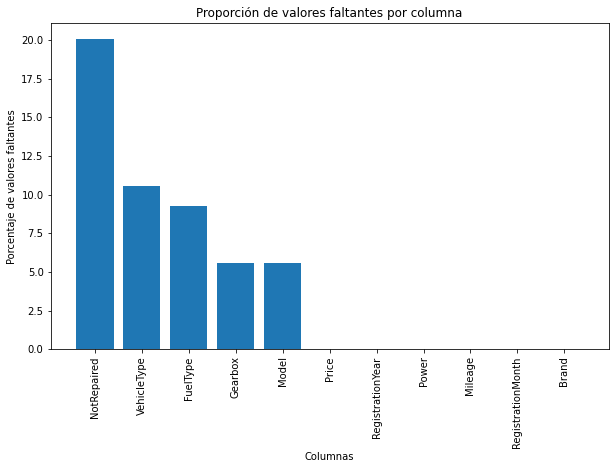

In [ ]:
missing_percentages = df.isnull().sum() / len(df) * 100
missing_percentages = missing_percentages.sort_values(ascending=False)
# Gráfico de barras de la proporción de valores faltantes
plt.figure(figsize=(10, 6))
plt.bar(missing_percentages.index, missing_percentages)
plt.xticks(rotation=90)
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de valores faltantes')
plt.title('Proporción de valores faltantes por columna')
plt.show()

In [ ]:
# Imputando Gearbox con 'others' debido a que no estaban especificados
df['Gearbox'].fillna('others', inplace=True)
df['Gearbox'].isna().sum()

0

In [ ]:
# Imputando notrepaired con 'unknown'
df['NotRepaired'].fillna('unknown', inplace=True)
df['NotRepaired'].isna().sum()

0

In [ ]:
# Imputando VehicleType con 'unknown'
df['VehicleType'].fillna('unknown', inplace=True)
df['VehicleType'].isna().sum()

0

In [ ]:
# Imputando VehicleType con 'unknown'
df['Model'].fillna('unknown', inplace=True)
df['Model'].isna().sum()

0

In [ ]:
# Imputando VehicleType con 'unknown'
df['FuelType'].fillna('unknown', inplace=True)
df['FuelType'].isna().sum()

0

In [ ]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

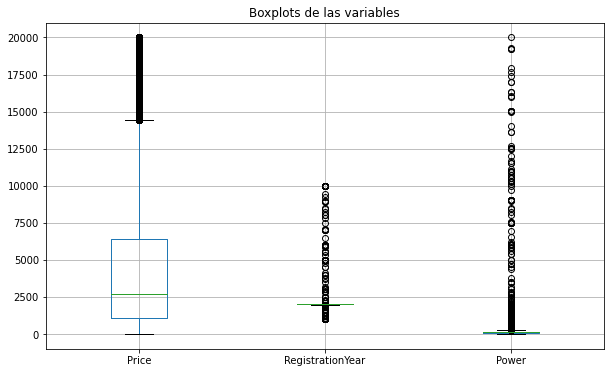

Outliers en la variable "Price":
1         18300
8         14500
14        17999
33        18000
50        14800
          ...  
354259    15000
354279    16500
354286    16500
354306    16999
354319    19800
Name: Price, Length: 18979, dtype: int64

Outliers en la variable "RegistrationYear":
7         1980
15        1910
28        1981
39        1984
91        1984
          ... 
354063    1970
354165    1981
354286    1973
354302    1984
354316    1957
Name: RegistrationYear, Length: 6309, dtype: int64

Outliers en la variable "Power":
41         306
59         286
113        265
125        286
172        305
          ... 
354260    1103
354281     286
354306     269
354337     445
354354     260
Name: Power, Length: 7340, dtype: int64



In [ ]:
# Variables de interés
variables = ['Price', 'RegistrationYear', 'Power']

# Visualización de boxplots
plt.figure(figsize=(10, 6))
df[variables].boxplot()
plt.title('Boxplots de las variables')
plt.show()

# Análisis estadístico
outliers = {}

for var in variables:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar outliers
    outliers[var] = df[(df[var] < lower_bound) | (df[var] > upper_bound)][var]

# Imprimir outliers encontrados
for var, outlier_vals in outliers.items():
    if not outlier_vals.empty:
        print(f'Outliers en la variable "{var}":')
        print(outlier_vals)
        print()

In [ ]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [ ]:
# Definir umbrales para identificar outliers
year_threshold = 2023
power_threshold = 200
price_threshold = 1050

# Filtrar los datos sin outliers
df_filtered = df[
    (df['Price'] >= price_threshold) &
    (df['RegistrationYear'] <= year_threshold) &
    (df['Power'] <= power_threshold)
]

# Verificar el nuevo tamaño del DataFrame filtrado
print("Tamaño del DataFrame filtrado:", df_filtered.shape)
print(df_filtered.info())

Tamaño del DataFrame filtrado: (244459, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 244459 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              244459 non-null  int64 
 1   VehicleType        244459 non-null  object
 2   RegistrationYear   244459 non-null  int64 
 3   Gearbox            244459 non-null  object
 4   Power              244459 non-null  int64 
 5   Model              244459 non-null  object
 6   Mileage            244459 non-null  int64 
 7   RegistrationMonth  244459 non-null  int64 
 8   FuelType           244459 non-null  object
 9   Brand              244459 non-null  object
 10  NotRepaired        244459 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.4+ MB
None


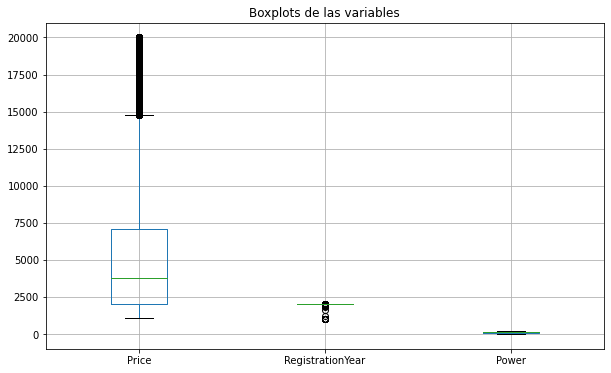

In [ ]:
# Variables de interés
variables = ['Price', 'RegistrationYear', 'Power']

# Visualización de boxplots
plt.figure(figsize=(10, 6))
df_filtered[variables].boxplot()
plt.title('Boxplots de las variables')
plt.show()

# Análisis estadístico
outliers = {}

for var in variables:
    Q1 = df_filtered[var].quantile(0.25)
    Q3 = df_filtered[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar outliers
    outliers[var] = df_filtered[(df_filtered[var] < lower_bound) | (df_filtered[var] > upper_bound)][var]

In [ ]:
df_filtered.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,244459.000000,244459.000000,244459.000000,244459.000000,244459.000000
mean,5276.941573,2004.178431,107.070846,124885.420459,6.007155
std,4211.059772,9.746895,48.778492,38836.748084,3.599643
min,1050.000000,1000.000000,0.000000,5000.000000,0.000000
25%,2000.000000,2001.000000,75.000000,100000.000000,3.000000
50%,3800.000000,2005.000000,109.000000,150000.000000,6.000000
75%,7100.000000,2008.000000,140.000000,150000.000000,9.000000
max,20000.000000,2019.000000,200.000000,150000.000000,12.000000


## Entrenamiento del modelo

In [ ]:
# Se hace un dummy con las variables categoricas
df_encoded = pd.get_dummies(df_filtered, columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'])

In [ ]:
# Se declaran caracteristicas y objetivo
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

In [ ]:
# Definir modelos en variables para simplificar su uso
linear_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = lgb.LGBMRegressor()
catboost_model = CatBoostRegressor(iterations=100)
xgb_model = xgb.XGBRegressor()

In [ ]:
# Se divide el conjunto en entrenamiento y en prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
%%time
# Definir los hiperparámetros a ajustar
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [1, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4]
}

# Realizar la búsqueda aleatoria de hiperparámetros
rf_random = RandomizedSearchCV(rf_model, param_grid, n_iter=5, cv=3, scoring='neg_root_mean_squared_error')
rf_random.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_rf_model = rf_random.best_estimator_
best_rf_params = rf_random.best_params_

# Entrenar el mejor modelo con los datos completos
best_rf_model.fit(X_valid, y_valid)

CPU times: user 57.2 s, sys: 1.16 s, total: 58.3 s
Wall time: 58.3 s


RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=10)

In [ ]:
# Random Forest mejores parametros
rf_model_best = RandomForestRegressor(max_depth=5, min_samples_leaf=4, n_estimators=20, min_samples_split=5)

In [ ]:
%%time
# Definir los hiperparámetros a ajustar
param_grid = {
    'num_leaves': [20, 30],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [10, 20, 30]
}

# Realizar la búsqueda en cuadrícula de hiperparámetros
lgb_grid = GridSearchCV(lgb_model, param_grid, cv=2, scoring='neg_root_mean_squared_error')
lgb_grid.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_lgb_model = lgb_grid.best_estimator_
best_lgb_params = lgb_grid.best_params_

# Entrenar el mejor modelo con los datos completos
best_lgb_model.fit(X_valid, y_valid)

CPU times: user 39.3 s, sys: 2.45 s, total: 41.7 s
Wall time: 41.9 s


LGBMRegressor(n_estimators=30, num_leaves=30)

In [ ]:
# LGBM mejores parametros
lgb_model_best = lgb.LGBMRegressor(n_estimators=30, num_leaves=30)

In [ ]:
%%time
# Crear un objeto Pool para los datos
pool = Pool(X_train, y_train)

# Definir los hiperparámetros a ajustar
param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.1, 0.01]
}

# Crear el modelo base de CatBoost
catboost_model = CatBoostRegressor()

# Realizar la búsqueda en cuadrícula de hiperparámetros
catboost_grid = GridSearchCV(catboost_model, param_grid, cv=3, scoring='neg_root_mean_squared_error')
catboost_grid.fit(X_train, y_train)

# Obtener el mejor modelo y sus hiperparámetros
best_catboost_model = catboost_grid.best_estimator_
best_catboost_params = catboost_grid.best_params_

# Entrenar el mejor modelo con los datos completos
best_catboost_model.fit(X_valid, y_valid)

0:	learn: 3990.2834193	total: 61.8ms	remaining: 6.12s
1:	learn: 3799.4508127	total: 78.2ms	remaining: 3.83s
2:	learn: 3629.3908779	total: 94ms	remaining: 3.04s
3:	learn: 3481.2811877	total: 110ms	remaining: 2.65s
4:	learn: 3351.1982556	total: 126ms	remaining: 2.39s
5:	learn: 3226.7498901	total: 141ms	remaining: 2.2s
6:	learn: 3119.0900338	total: 158ms	remaining: 2.09s
7:	learn: 3024.8528470	total: 175ms	remaining: 2.01s
8:	learn: 2946.8497349	total: 190ms	remaining: 1.92s
9:	learn: 2862.2760544	total: 205ms	remaining: 1.85s
10:	learn: 2797.3546241	total: 222ms	remaining: 1.79s
11:	learn: 2737.4424482	total: 236ms	remaining: 1.73s
12:	learn: 2690.9386600	total: 253ms	remaining: 1.69s
13:	learn: 2642.2687755	total: 268ms	remaining: 1.65s
14:	learn: 2602.3918810	total: 285ms	remaining: 1.61s
15:	learn: 2566.2936980	total: 302ms	remaining: 1.58s
16:	learn: 2531.8130886	total: 318ms	remaining: 1.55s
17:	learn: 2501.0400162	total: 333ms	remaining: 1.52s
18:	learn: 2472.1879402	total: 355ms	r

In [ ]:
%%time
# Entrenar modelo lineal y XGB sin hiperparametros
linear_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

CPU times: user 4min 44s, sys: 2.33 s, total: 4min 46s
Wall time: 4min 46s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Análisis del modelo

In [ ]:
%%time
# Realizar predicciones con los conjuntos de prueba:
linear_predictions = linear_model.predict(X_test)
rf_predictions = best_rf_model.predict(X_test)
lgb_predictions = best_lgb_model.predict(X_test)
catboost_predictions = best_catboost_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

CPU times: user 1.21 s, sys: 146 ms, total: 1.35 s
Wall time: 1.31 s


In [ ]:
%%time
# Evaluar la calidad de las predicciones:
linear_rmse = mean_squared_error(y_test, linear_predictions, squared=False)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
lgb_rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
catboost_rmse = mean_squared_error(y_test, catboost_predictions, squared=False)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

print("RECM (Root Mean Squared Error) para cada modelo:")
print("Regresión Lineal:", linear_rmse)
print("Bosque Aleatorio:", rf_rmse)
print("LightGBM:", lgb_rmse)
print("CatBoost:", catboost_rmse)
print("XGBoost:", xgb_rmse)

RECM (Root Mean Squared Error) para cada modelo:
Regresión Lineal: 2811.332881549718
Bosque Aleatorio: 2417.7858044501454
LightGBM: 1941.1454960698168
CatBoost: 1776.012003584905
XGBoost: 1661.127141548561
CPU times: user 3.15 ms, sys: 3.73 ms, total: 6.89 ms
Wall time: 4.24 ms


- Al incio del proyecto se tuvo que realizar un procesamiento de datos rellenando los valores ausentes de Gearbox y NotRrepaired con others y unknown respectivamente esto debido a que no contamos con suficiente informacion para imputar los valores ausentes, continuo a eso se realizaron diferentes diccionarios vacios con bucles for que exploraran los datos con relacion a una columna correlacionada a la variable para encontrar similitudes que pudieran imputar en los datos ausentes con datos similares, dicho lo anterior se realizaron 6 modelos diferentes siendo regresion lineal, bosque aleatorio, LGBM, CatBoost y XGBoost para comprobar cual tenia el RMSE con mejor resultado dando que con las predicciones y con la evaluacion de los modelos utilizando la metrica de RMSE podemos observar que el mejor modelo es XGBoost con un RMSE  de 1647.08.